## Problem 7.10

Let us consider the case with $n$ elements (nodes from $x_1$ to $x_{n+1}$). Because the final node ($n+1$) has its temperature is fixed, we do not need to solve for this node. The elements of the local diffusivity matrix for nodes $1,...n$ are given in 7.60-7.62.

\begin{align*}
K_{11}       &= k^1_{11} \\ 
K_{A-1\,A}   &= k^{A-1}_{12} \\ 
K_{A\,A}     &= k^{A-1}_{22} + k^{A}_{11} \\ 
\end{align*}

In Problem 7.9, it is shown that 

\begin{equation}
k^A_{ab} = \frac{(-1)^{a+b}}{\Delta x_A}
\end{equation}
which holds for $A = 1,\, n$ inclusive.

Similarly the heat supply vector may be written as 

\begin{align*}
F_{1}        &= f^1_{1} + H_0 \\ 
F_{A}        &= f^{A-1}_{2} + f^{A}_{1} \\ 
F_{n+1} &= f^{n}_{2} + \frac{\theta_1}{\Delta x_n}
\end{align*}

where 
\begin{equation}
f_a^A = \int_{x_A}^{x_{A+1}} N_a \, h \:\mathrm{d}x
\end{equation}

For example, the local forcing vectors from the first 3 elements would be: 

\begin{equation}
\begin{bmatrix} 
F_1   \\
F_2       \\ 
\end{bmatrix}  \leftarrow 
\underbrace{\begin{bmatrix} 
f^1_{1} + H_0   \\
f_{2}^{1}       \\ 
\end{bmatrix}}_{\text{Element 1 contribution}} \quad, \quad
\begin{bmatrix} 
F_2   \\
F_3       \\ 
\end{bmatrix}  \leftarrow 
\underbrace{\begin{bmatrix} 
f_{1}^{2}    \\
f_{2}^{2}   \\ 
\end{bmatrix}}_{\text{Element 2 contribution}}
\quad, \quad
\begin{bmatrix} 
F_3   \\
F_4       \\ 
\end{bmatrix}  \leftarrow 
\underbrace{\begin{bmatrix} 
f_{1}^{3}    \\
f_{2}^{3}   \\ 
\end{bmatrix}}_{\text{Element 3 contribution}}
\end{equation}


So now let us determine the values of $f_a^A$ for the cases of $h=0$ and $h=1$ by solving Eqn 7.69, 
\begin{equation}
f_a^A = \int_{x_{A}}^{x_{A+1}} N_a \, h(x) \: \mathrm{d}x \quad. 
\end{equation}
Evidently $f_a^A = 0$ when $h=0$. When $h(x) = 1$, we get
\begin{align*}
f_a^A &= \int_{x_{A}}^{x_{A+1}} \frac{1}{\Delta x_A} \left( x_{A+1} - x \right) \: \mathrm{d}x \\ 
      &= \frac{\Delta x_A}{2} 
\end{align*}


### Case 1: h = 0

Note here that the textbook has indices going from $1$ to $n$. Python indexes starting at 0 so our indices will be from $0$ to $n$ and the first element of a matrix will be $K_{00}$. 

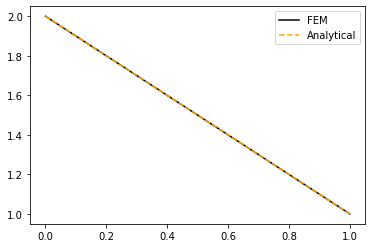

In [34]:
import numpy as np 
import scipy.linalg as sl
import matplotlib.pyplot as plt 
# Boundary conditions: 
theta_1 = 1
H0      = 1

nelem   = 10        # number of elements, n
np1     = nelem + 1 # n+1

# Global domain node locations
x = np.linspace(0, 1, np1)

# Compute Delta x for each element: 
dx = x[1:] - x[:-1]

# Create our diffusivity matrix: 
K = np.zeros((nelem, nelem))

# Create global heating matrix:
F = np.zeros(nelem)

for ielem in range(nelem): 
    # Compute local diffusivity matrix for this element: 
    # using 7.65
    kloc = np.zeros((2,2))
    kloc[0,0] = 1
    kloc[1,1] = 1
    kloc[0,1] = -1
    kloc[1,0] = -1
    
    # Multiply by grid spacing
    kloc *= (1/dx[ielem])

    # Add to the global matrix:
    if ielem == nelem -1: 
        # For the last element we are ignoring the 
        #contributions from the n + 1 node 
        K[ielem, ielem] += kloc[0,0]
    else:
        K[ielem:ielem+2, ielem:ielem+2] += kloc
    
    
    # Create local forcing vector for element: 
    # In the case that h = 0, we know floc is also
    # 0 except at the boundaries
    floc = np.zeros(2)
    if ielem == 0: 
        floc[0] += H0 
    elif ielem == nelem-1: 
        floc[0] += theta_1/dx[ielem]
    
    
    # Add to the global vector:
    # For the nth element we need to edit the 
    # indexing since only the nth (not n+1th) node 
    # is added 
    if ielem == nelem-1:
        F[ielem] += floc[0]
    else: 
        F[ielem:ielem+2] += floc  

        
# Compute d as K^-1 * F 
Kinv = np.linalg.inv(K)
d = np.matmul(Kinv, F)

# The total temperature field includes the n+1 node
# which is equal to theta_1
temp = np.zeros(np1)
temp[:-1] = d
temp[-1]  = theta_1


We can now compare against the analytical solution 
\begin{equation}
\theta(x) = \theta_1 + (1-x)H_0
\end{equation}

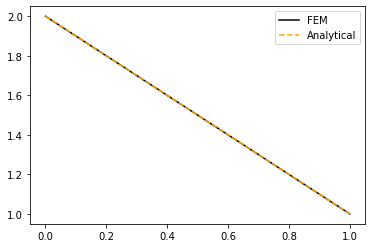

In [36]:
# Plot against analytical
# When h is 0: 
analytical = theta_1 + (1-x)*H0

fig, ax = plt.subplots()

ax.plot(x, temp, 'k')
ax.plot(x, analytical, '--', color='orange')
ax.legend(['FEM', 'Analytical']);

### Case 1: h = 0
Now lets consider the case when $h=1$. This does not affect the diffusivity matrix, only the force matrix, so lets update that and rerun the code: 

In [30]:
# Reinitialise global heating matrix:
F = np.zeros(nelem)

for ielem in range(nelem): 
    # Create local forcing vector for element: 
    # In the case that h = 0, we know floc is also 0 
    # except at the boundaries
    floc = np.zeros(2)
    if ielem == 0: 
        floc[0] += H0 + dx[0]/2
        floc[1] += dx[0]/2
    elif ielem == nelem-1: 
        floc[0] += (theta_1/dx[ielem]) + dx[-1]/2
    else: 
        floc[0] +=  dx[ielem-1]/2
        floc[1] +=  dx[ielem]/2
        
    # Add to the global vector:
    # For the nth element we need to edit the indexing
    # since only the nth (not n+1th) node is added 
    if ielem == nelem-1:
        F[ielem] += floc[0]
    else: 
        F[ielem:ielem+2] += floc 

d = np.matmul(Kinv, F)


# The total temperature field includes the n+1 node
# which is equal to theta_1
temp = np.zeros(np1)
temp[:-1] = d
temp[-1]  = theta_1


Finally, let us compare against the analytical solution (7.19) for $h(x)=1$ which ends up being 

\begin{equation}
    \theta(x) = \theta_1 + (1-x) H_0 + \frac{1}{2}(1-x^2) \quad.
\end{equation}

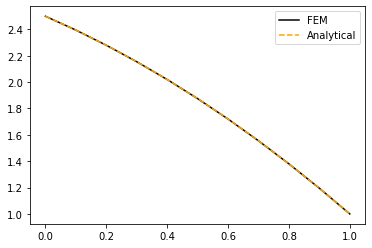

In [33]:
fig, ax = plt.subplots()

# Analytical solution in this case 

theta = theta_1 + (1-x)*H0 +  0.5*(1 - x**2)

ax.plot(x, temp, 'k');
ax.plot(x, theta, '--', color='orange');
ax.legend(['FEM', 'Analytical']);